**Исследование данных о российском кинопрокате **   
**Описание проекта**  

Заказчик этого исследования — Министерство культуры Российской Федерации. Вам нужно изучить рынок российского кинопроката и выявить текущие тренды. Уделите внимание фильмам, которые получили государственную поддержку. Попробуйте ответить на вопрос, насколько такие фильмы интересны зрителю. Вы будете работать с данными, опубликованными на портале открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.  

**Введение**  

Нашей задачей является выявление трендов современного Российского кинематографа, важна будет оценить насколько эффективно Министерство культуры Российской Федерации и Фонд кино инвестирует в кинематогроф для этого выполним следующие задачи:

1. Познакомимся с данными

2. Проверим наш датафрейм на погрешности такие как дубликаты, пропуски и так далее

3. Проведем исследовательский анализ выпуска фильмов и их сборов

4. Проведем анализ фильмов получивших гос. поддержки для выявления общих тенденций

## Исследование данных о российском кинопрокате



### Шаг 1. Откроем файлы с данными и объедините их в один датафрейм.


In [ ]:
import pandas as pd

In [ ]:
movies = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_movies.csv')
shows = pd.read_csv('https://code.s3.yandex.net/datasets/mkrf_shows.csv')

In [ ]:
movies['puNumber'] = movies['puNumber'].replace('нет',0)
movies['puNumber'] = movies['puNumber'].astype('int64')
shows['puNumber'] = shows['puNumber'].astype('int64')

data = movies.merge(shows, on = 'puNumber', how = 'outer')

Получил два датасета. Изучил данные и обнаружил что с чем можно связать. При попытке объединить таблицы вылезла ошибка, что в датасете movies присутствует слово нет, обозначающее отсутствие данного значения. Произвел замену нет на 0 и преобразовал столбец в integer. Совершил объеднинение датасетов. Тех pdNumber, что есть в shows нет в movies

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверим типы данных

In [ ]:
data['refundable_support'] = data['refundable_support'].fillna(0)
data['nonrefundable_support'] = data['nonrefundable_support'].fillna(0)
data['budget'] = data['budget'].fillna(0)
data['financing_source'] = data['financing_source'].fillna("без гос участия")
data['ratings'] = data['ratings'].fillna('0')
data['box_office'] = data['box_office'].fillna('0')

data['show_start_date'] = pd.to_datetime(data['show_start_date'], format = '%Y-%m-%d')
data['puNumber'] = data['puNumber'].astype('int64')
data['title'] = data['title'].astype('string')
data['film_studio'] = data['film_studio'].astype('string')
data['director'] = data['director'].astype('string')
data['production_country'] = data['production_country'].astype('string')
data['budget'] = data['budget'].astype('int64')
data['refundable_support'] = data['refundable_support'].astype('int64')
data['nonrefundable_support'] = data['nonrefundable_support'].astype('int64')
data['box_office'] = data['box_office'].astype('int64')

In [ ]:
data.info()
print(data['nonrefundable_support'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   string             
 1   puNumber               7486 non-null   int64              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7468 non-null   string             
 5   production_country     7484 non-null   string             
 6   director               7477 non-null   string             
 7   producer               6918 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     7486 non-null   int64              
 10  nonrefundable_support  7486 non-null   int64              
 11  budget                 7486 non-null   int64            

#### Шаг 2.2. Изучим пропуски в датафрейме


In [ ]:
data['production_country'] = data['production_country'].fillna('2019')
data['production_country'] = data['production_country'].replace('2019' , 'не удалось определить')
data['genres'] = data['genres'].fillna('другое')
data['support'] = data['refundable_support'] + data['nonrefundable_support']
data['support'] = data['support'].astype('int64')

ratings_to_replace = ['99%','97%','83%', '64%', '91%', '94%', '62%', '79%', '90%', '19%', '88%', '28%', '89%', '98%']
ratings_replace = ['9.9', '9.7', '8.3', '6.4', '9.1', '9.4', '6.2', '7.9', '9.0', '1.9', '8.8', '2.8', '8.9', '9.8']
data['ratings'] = data['ratings'].replace(ratings_to_replace , ratings_replace)
data['ratings'] = data['ratings'].astype('float64')

Обнаружены пропуски в:
film_studio - непонятно как определить студию производителя. Так что оставляю
production_country - непонятно как определить страну. Так что оставляю. Но были обнаружены 2 выбивающихся значения: 2019 и nan, произвожу замену на "не удалось определить"
director - непонятно как определить режиссера. Так что оставляю
producer - непонятно как определить сценариста. Так что оставляю
refundable_support - если есть значения, то значит это фильмы с гос участием, но если значений нет, то значит на частные деньги были сняты. Пустоты оставляю, изменя их на ноль
nonrefundable_support - если есть значения, то значит это фильмы с гос участием, но если значений нет, то значит на частные деньги были сняты. Пустоты оставляю, изменя их на ноль
budget - не ясно как определить бюджет. Количество значений совпдает с теми, где есть данные по гос участию. Так что предполагаю, что это просто фильмы с гос участием, где есть финансовые данные. Данных просто нет и мы не можем посчитать, на основе имеющихся данных, сколько было потрачено на создание фильма. Оставляю значения как есть, изменя их на ноль
financing_source - если есть значения, то значит это фильмы с гос участием, но если значений нет, то значит на частные деньги были сняты. Пустоты оставляю, изменю пустоты на "без гос участия"
ratings - рейтинг фильма вещь субъективная, так что оставляю. Проценты меняю на float64
genres -  в теории можно определит жанр по названию, но это не будет точной интерпритацией. У нас есть тип фильма и там категория прочее. Сделаю такую же
box_office - кассу фильма тоже тяжело посчитать.

#### Шаг 2.3. Изучим дубликаты в датафрейме


In [ ]:
dublicates = data[data['puNumber'].duplicated()]
#data = data.drop_duplicates()
#data['puNumber'] = data['puNumber'].drop_duplicates()
#Алекс и Эмма/Алекс и Эмма, Аватар_/Аватар_,Американский пирог: Все в сборе/Американский пирог: Все в сборе. Пример дубликатов
dublicates_titles = data[data['title'].duplicated()]
#data_wo_duplic_titles = data[data['title'].drop_duplicates()]
data['title'] = data['title'].str.lower()

Обнаружил дубликаты в номере прокатного удостоверения. Есть пустоты, которые я удаляю. А фильмы с одинаковыми номерами проката также можно удалить от дублей, так как они без гос участия, а они нам меньше интересны. Да и про деньги там ничего не сказано. Есть также странные названия фильмов, точнее они считаются дубликатами по названиям. Применил к ним str.lower, значения нам нужны по box_office. Планировал удалить полностью дубликаты, но получается так что при дальнейшем анализе, значения по кассе нулями станотся

#### Шаг 2.4. Изучим категориальные значения



In [ ]:
# Пример 'США - Франция - Турция'
#display(data['production_country'].unique())

data['type'].str.strip()
data['production_country'].str.strip()
#data['genres'].str.strip()

0                           США
1                          СССР
2                           США
3                           США
4                           США
                 ...           
7481             Великобритания
7482                        США
7483               США - Канада
7484    Республика Кипр, Россия
7485    Республика Кипр, Россия
Name: production_country, Length: 7486, dtype: string

Пробелы есть в начале слов. Где-то есть запятые, а где-то тире

#### Шаг 2.5. Проверим количественные значения


In [ ]:
display(data[data['budget'] != 0 ])

def supp_bigger_budget(support,budget):
    if support > budget:
        return 'yes'
    else:
        return 'no'

data['supp_bigger_budget'] = data.apply(lambda x: supp_bigger_budget(x.support, x.budget), axis=1)

data = data.query('supp_bigger_budget == "no"')

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,support
1281,пока еще жива,111005313,2013-10-11 12:00:00+00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0,26500000,79411900,Министерство культуры,8.1,"драма,мелодрама",365353,26500000
1448,бесславные придурки,111003314,2014-03-28 12:00:00+00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0,26000000,37142857,Министерство культуры,0.0,другое,28140,26000000
1498,невидимки,111004213,2013-09-10 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0,107847945,176023490,Фонд кино,5.3,"комедия,фантастика",19957031,107847945
1524,берцы,111004314,2014-05-05 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0,28000000,40574140,Министерство культуры,4.2,драма,55917,28000000
1792,братья ч,111004414,2014-04-23 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0,25000000,40015122,Министерство культуры,6.4,драма,232100,25000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,союз спасения,111022019,2019-12-26 12:00:00+00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,100000000,400000000,980000000,Фонд кино,6.0,"история,биография,драма",717703185,500000000
7466,иван царевич и серый волк 4,114005019,2019-12-20 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,100000000,0,190000000,Фонд кино,6.7,"мультфильм,приключения,семейный",501069235,100000000
7474,вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,100000000,400000000,944000000,Фонд кино,5.7,"фантастика,боевик",0,500000000
7476,я свободен,111023019,2019-12-26 12:00:00+00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0,30000000,46154000,Министерство культуры,5.9,драма,0,30000000


Бюджет некоторых фильмов выше, чем в него вложили. Удаляю их

#### Шаг 2.6. Добавим новые столбцы





- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [ ]:
data['year_premier'] = pd.DatetimeIndex(data['show_start_date']).year

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

In [ ]:
data['name_and_family_name'] = data['director'].str.split(',',1)

def split_up(what_to_split):
    text = ''
    text = what_to_split.split(',')
    return text

data['main_genre'] = data['genres'].apply(split_up)
print(data['genres'].head(25))
print(data['main_genre'].head(25))

0         боевик,драма,мелодрама
1                  драма,военный
2      фантастика,боевик,триллер
3      фантастика,боевик,триллер
4      фантастика,боевик,триллер
5                          драма
6              мелодрама,комедия
7       мюзикл,мелодрама,комедия
8               комедия,криминал
9              мелодрама,комедия
10       боевик,триллер,детектив
11      боевик,драма,приключения
12                   драма,спорт
13       триллер,драма,мелодрама
14             комедия,мелодрама
15                         драма
16       драма,мелодрама,комедия
17               драма,мелодрама
18             мелодрама,комедия
19                         драма
20                 драма,история
21      драма,мелодрама,семейный
22    комедия,мелодрама,криминал
23                 драма,военный
24                       комедия
Name: genres, dtype: object
0         [боевик, драма, мелодрама]
1                   [драма, военный]
2      [фантастика, боевик, триллер]
3      [фантастика, боевик, триллер]

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

In [ ]:
data['share_of_goverment'] = (data['support']) / data['budget']
print(data['share_of_goverment'].median())

0.5922645480995804


Медианное значение около 59%

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

<AxesSubplot:>

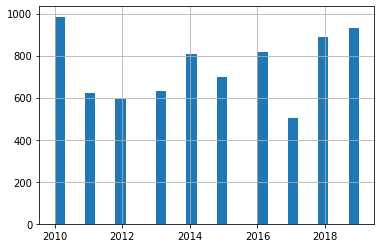

In [ ]:
data['year_premier'].hist(bins = 30)

С учетом отсортированных данных. Мы наблюдаем пик в 2010 году (около 1000 фильмов), а после в 2019 году (около 950 фильмов)

In [ ]:
#data.info()
share_box_office = 3134 / 7486
print(share_box_office)

0.4186481432006412


Мы имеем информацию по прокату у около 42% фильмов

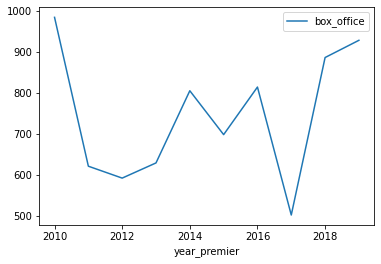

In [ ]:
data_pivot_plot = data.pivot_table(index = 'year_premier', values = 'box_office', aggfunc = 'count').plot()

Видно, что количество данных о прокате растет с 2011 года и достигает пика в 2018 и 2019 годах. То есть мы имеем больше всего данных в этих двух годах. Но наибольшее значение встречается в 2010 году

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

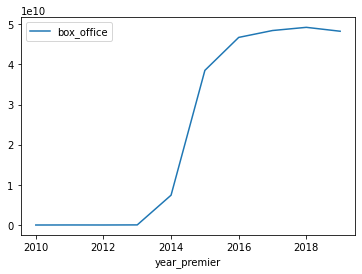

In [ ]:
data_pivot_plot = data.pivot_table(index = 'year_premier', values = 'box_office', aggfunc = 'sum').plot()

Касса уверенно держится с 2016 года. с 2010 по 2014 года фильмами особо не занимались и не следили у кого какой прокат

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

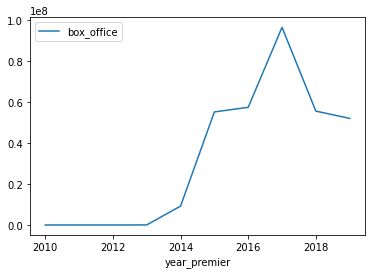

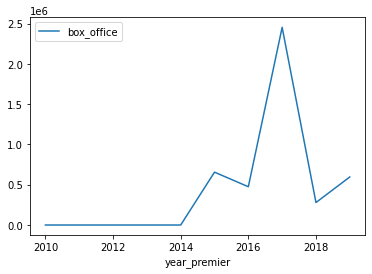

In [ ]:
box_offce_mean = data.pivot_table(index = 'year_premier', values = 'box_office', aggfunc = 'mean').plot()
box_offce_median = data.pivot_table(index = 'year_premier', values = 'box_office', aggfunc = 'median').plot()


Видны подъемы с 2014 года, что мы подтвердили еще раз. Самым прибыльным годом стал 2017 год. Как с точки зрения среднего значения около 100000000, так и с точки зрения медианного значения около 25000000

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

In [ ]:
data_pivot_plot_age = (data.query('year_premier >= 2015')
                       .pivot_table(index = 'age_restriction', columns = 'year_premier', values = 'box_office', aggfunc = 'sum', margins=True)
                      )
display(data_pivot_plot_age)

year_premier,2015,2016,2017,2018,2019,All
age_restriction,,,,,,
«0+» - для любой зрительской аудитории,379054567,150228839,229598930,32449001,17746066,809077403
«12+» - для детей старше 12 лет,13419509551,11150762083,7851427659,14267291636,12680198743,59369189672
«16+» - для детей старше 16 лет,10781600555,16594249440,18694590950,16278405884,12753418927,75102265756
«18+» - запрещено для детей,5430350591,6793929771,9651495581,8760085436,10121796238,40757657617
«6+» - для детей старше 6 лет,8517311803,12053145991,12031034131,9913759264,12704941792,55220192981
All,38527827067,46742316124,48458147251,49251991221,48278101766,231258383429


Больше всего денег собрала с 2015 по 2019 года категория 16+ около 75000000000 рублей. Самым выгодным для этой категории был 2017 год. В целом эта категори либо всегда на 1 места по сборам или на втором. Скорее всего то зависит от выходящих фильмов, какие-то крутые и известные франшизы всегда очень много собирают. Возможно фильмов банально больше выходит. Один год был более удачным на фильмы, а другой менее. Проверим это на количестве фильмов

In [ ]:
data_pivot_plot_age = (data.query('year_premier >= 2015')
                       .pivot_table(index = 'age_restriction', columns = 'year_premier', values = 'box_office', aggfunc = 'count', margins=True)
                      )
display(data_pivot_plot_age)

year_premier,2015,2016,2017,2018,2019,All
age_restriction,,,,,,
«0+» - для любой зрительской аудитории,50,73,44,77,73,317
«12+» - для детей старше 12 лет,136,134,70,243,203,786
«16+» - для детей старше 16 лет,246,268,152,234,266,1166
«18+» - запрещено для детей,191,245,172,222,255,1085
«6+» - для детей старше 6 лет,76,95,65,111,132,479
All,699,815,503,887,929,3833


Больше всего фильмов выходило в категории 16+. Далее 18+. Получается так что категория с наибольшем количеством фильмов собирает самую большую кассу. На втором месте категория 12+, хотя и фильмов вышло в 1.5 раза меньше чем у первого места. Все же получается так что эти 4 года разницы отнимают большую сумму денег.

In [ ]:
data_movies_category = data.query('year_premier >= 2015').groupby('age_restriction').agg({'box_office':['count','sum','mean']})
data_movies_category['percent'] = data_movies_category['box_office']['sum']/data_movies_category['box_office']['count']
data_movies_category['percent'] = data_movies_category['percent'] / 1000000
display(data_movies_category)

box_office                             \
                                            count          sum          mean   
age_restriction                                                                
«0+» - для любой зрительской аудитории        317    809077403  2.552295e+06   
«12+» - для детей старше 12 лет               786  59369189672  7.553332e+07   
«16+» - для детей старше 16 лет              1166  75102265756  6.441018e+07   
«18+» - запрещено для детей                  1085  40757657617  3.756466e+07   
«6+» - для детей старше 6 лет                 479  55220192981  1.152822e+08   

                                           percent  
                                                    
age_restriction                                     
«0+» - для любой зрительской аудитории    2.552295  
«12+» - для детей старше 12 лет          75.533320  
«16+» - для детей старше 16 лет          64.410176  
«18+» - запрещено для детей              37.564661  
«6+» - для детей старше 6 лет           115.282240

Но получается так что самыми прибыльными фильмы оказываются категории 6+ и 12+. Их хоть и мало, но охват аудитории у них внушительный. 16+ берет первое место по сумме кассы за счет большего количества фильмов. Наименее невыгодные фильмы это 0+

Общий вывод. Данные используются за период 2015 по 2019 года. Больше всего фильмов выходит в категории 16+ и самая большая касса у данной категории. Эта категория берет первые места за счет количства вышедших фильмов. Окупаются они среднее, есть куда более прибыльные категории. Например 6+ или 12+. Их хоть и выходит меньше, но в среднем они приносят больше всего денег.

### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

In [ ]:
data_gov = (data.query('year_premier >= 2015').query('support != 0').query('box_office != 0').query('budget != 0').query('ratings != 0')
                       .pivot_table(index = 'title', values = ['support', 'budget', 'box_office', 'ratings']))

data_gov['box_bud'] = data_gov['box_office']/data_gov['budget']
data_gov['sup_bud'] = data_gov['support']/data_gov['budget']

#display(data_gov.sort_values(by='box_bud', ascending = False)) # сортировка по самым окупаемым фильмам
#display(data_gov.sort_values(by='sup_bud', ascending = False)) # сортировка по доле гос поддержки в бюджете

print(data_gov['ratings'].mean())
plus_films = data_gov.query('box_bud >= 1')

print(plus_films.count()) # фильмов, которые окупились всего 62

print(plus_films['ratings'].mean()) # средний рейтинг около 6.1
print(plus_films['box_bud'].mean()) # среди окупившихся фильмов средний показатель окупаемости около 2.7x

print(data_gov['ratings'].mean())
mean_support = data_gov['support'].mean()
print(mean_support)

6.03579335793358
box_office    62
budget        62
ratings       62
support       62
box_bud       62
sup_bud       62
dtype: int64
6.169354838709676
2.7452705245545523
6.03579335793358
61778039.12546126


In [ ]:
data_genres = (data.query('year_premier >= 2015').query('support != 0').query('box_office != 0').query('budget != 0').query('ratings != 0')
                       .pivot_table(index = 'genres', values = ['support', 'budget', 'box_office', 'ratings']))
data_genres['box_bud'] = data_genres['box_office']/data_genres['budget']
data_genres['sup_bud'] = data_genres['support']/data_genres['budget']
plus_films_genres = data_genres.query('box_bud >= 1')

#display(plus_films_genres)

#display(data_genres.sort_values(by='box_bud', ascending = False)) # сортировка по самым окупаемым фильмам
#display(data_genres.sort_values(by='support', ascending = False)) # сортировка по самым спонсируемым

,box_office,budget,ratings,support,box_bud,sup_bud
genres,,,,,,
"история,биография,драма",7.177032e+08,9.800000e+08,6.00,500000000.0,0.732350,0.510204
"драма,триллер,приключения",1.402255e+09,6.352839e+08,7.60,442104482.0,2.207289,0.695916
"история,боевик,фэнтези",5.904051e+08,5.000127e+08,6.40,350000000.0,1.180780,0.699982
"фэнтези,комедия,семейный",5.117755e+08,1.032906e+09,7.70,300000000.0,0.495472,0.290443
"детектив,триллер,криминал",5.587689e+07,4.537047e+08,5.80,300000000.0,0.123157,0.661223
...,...,...,...,...,...,...
"триллер,драма,фантастика",1.572434e+06,2.857143e+07,6.30,20000000.0,0.055035,0.700000
"фантастика,боевик,комедия",3.066912e+06,3.900000e+07,8.35,17500000.0,0.078639,0.448718
"мелодрама,криминал",5.652465e+06,4.577299e+07,4.35,16500000.0,0.123489,0.360475


In [ ]:
data_directors = (data.query('year_premier >= 2015').query('support != 0').query('box_office != 0').query('budget != 0').query('ratings != 0')
                       .pivot_table(index = 'director', values = ['support', 'budget', 'box_office', 'ratings']))
data_directors['box_bud'] = data_directors['box_office']/data_directors['budget']
data_directors['sup_bud'] = data_directors['support']/data_directors['budget']
plus_films_directors = data_directors.query('box_bud >= 1')

#display(plus_films_directors)

#display(data_directors.sort_values(by='box_bud', ascending = False)) # сортировка по самым окупаемым фильмам
display(data_directors.sort_values(by='support', ascending = False)) # сортировка по самым спонсируемым

,box_office,budget,ratings,support,box_bud,sup_bud
director,,,,,,
А.Кравчук,7.177032e+08,980000000.0,6.0,500000000.0,0.732350,0.510204
А.Мизгирев,3.642851e+08,684200536.0,6.6,450000000.0,0.532425,0.657702
Н.Лебедев,1.402255e+09,635283867.0,7.6,442104482.0,2.207289,0.695916
А.Мегердичев,2.779686e+09,590192191.0,7.5,400000000.0,4.709798,0.677745
И.Шурховецкий,5.904051e+08,500012729.0,6.4,350000000.0,1.180780,0.699982
...,...,...,...,...,...,...
Н.Кудряшова,1.109238e+06,27000000.0,5.9,15000000.0,0.041083,0.555556
Ю.Кара,3.347500e+05,40000000.0,9.4,10000000.0,0.008369,0.250000
Е.Жигаева,2.704970e+05,18166418.0,5.4,8000000.0,0.014890,0.440373


Максимальная поддержка от государства 70% от бюджета фильма.   
Медианноее значение 61%. Государство проспонсировало 271 фильма и только 62 фильма вышли в плюс. То есть около 23% фильмов окупаются при гос поддержке. Если фильм окупается, то достаточно хороiо и в среднем при окупившихся фильмов, окупаемость составляет в среднем 2.75х от его бюджета. Средний рейтинг окупившихся фильмов около 6.0, а среди всех фильмов около 6.0, что несильно меньше. Среднняя сумма поддержки государства составляет около 62 млн рублей. Самый популярный и наиболее окупаемый жанр это комедия. Окуп примерно в 5 раз от первоначального бюджета. Но больше всего любят вкладывать в историческо-драматические фильмы, а еще лучше туда биографию добавить. Тут намек на тренд на патриотизм и в какой степени пропоганду. Такие фильмы почти не отбивают кассу или выходят в небольшой плюс, что говорит о непопулярности таких картин. Самый окупаемый режиссер это А.Черномазов (псевдоним Алексей Нужный), его фильмы окупаются в почти 7.2 раза от первоначального бюджета. Больше всего нравится выделять деньги А.Кравчук и А.Мизгирев. Их картины не окупатся, это вопрос о целесообразности вложений в данных персон. А вот Н.Лебедев окупается в 2.2 раза от бюджета, но еще лучше А.Мегердичев с результатом в 4.7 раза от бюджета. Да и рейтинг фильмов выше у них около 7.5, по сравнению с 6.0 и 6.6 у первых двух лидеров.

### Шаг 5. Напишите общий вывод

Были полученны данные по вышедшим филмам с 2010 по 2019 года. Была проведена первичная оценка данных, выставленны необходимые типы данные, заменены или заполнены необходимыми значениями. Была проведена работа с дубликатами.

Для удобства анализы создавались необходиме переменные и столбцы.

Представленные данные несовсем полные. Всего данные с 2010 по 2019 года, но только с 2015 года они становтяся более менее полными. Видимо начиная с этого года государство куда болше стала проявлят интерес к этой области.

Больше всего фильмов выходит в категории 16+ и самая большая касса у данной категории. Эта категория берет первые места за счет количства вышедших фильмов. Окупаются они среднее, есть куда более прибыльные категории. Например 6+ или 12+. Их хоть и выходит меньше, но в среднем они приносят больше всего денег.

Максимальная поддержка от государства 70% от бюджета фильма. Медианноее значение 61%. Государство проспонсировало 271 фильма и только 62 фильма вышли в плюс. То есть около 23% фильмов окупаются при гос поддержке. Если фильм окупается, то достаточно хороiо и в среднем при окупившихся фильмов, окупаемость составляет в среднем 2.75х от его бюджета. Средний рейтинг окупившихся фильмов около 6.0, а среди всех фильмов около 6.0, что несильно меньше. Среднняя сумма поддержки государства составляет около 62 млн рублей. Самый популярный и наиболее окупаемый жанр это комедия. Окуп примерно в 5 раз от первоначального бюджета. Но больше всего любят вкладывать в историческо-драматические фильмы, а еще лучше туда биографию добавить. Тут намек на тренд на патриотизм и в какой степени пропоганду. Такие фильмы почти не отбивают кассу или выходят в небольшой плюс, что говорит о непопулярности таких картин. Самый окупаемый режиссер это А.Черномазов (псевдоним Алексей Нужный), его фильмы окупаются в почти 7.2 раза от первоначального бюджета. Больше всего нравится выделять деньги А.Кравчук и А.Мизгирев. Их картины не окупатся, это вопрос о целесообразности вложений в данных персон. А вот Н.Лебедев окупается в 2.2 раза от бюджета, но еще лучше А.Мегердичев с результатом в 4.7 раза от бюджета. Да и рейтинг фильмов выше у них около 7.5, по сравнению с 6.0 и 6.6 у первых двух лидеров.